In [39]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [25]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [26]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [27]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [28]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(autoload_with=engine)

In [29]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [30]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [31]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [32]:
# Find the most recent date in the data set.
first_row = session.query(Measurement).first()
first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x1f007b6ec30>,
 'prcp': 0.08,
 'station': 'USC00519397',
 'id': 1,
 'date': '2010-01-01',
 'tobs': 65.0}

In [33]:
# Find the most recent date in the data set.
most_recent_date = session.query(func.max(Measurement.date)).first()
most_recent_date

('2017-08-23',)

In [40]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
session.query(Measurement.date).order_by(Measurement.date.desc()).first()
# Calculate the date one year from the last date in data set.
query_date = dt.date(2017, 8, 23) - dt.timedelta(days=366)
query_date
# Perform a query to retrieve the data and precipitation scores
results = session.query(Measurement).filter(Measurement.date > query_date).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
df = pd.DataFrame([result.__dict__ for result in results])
df = df.drop(columns=['_sa_instance_state'])

# Sort the dataframe by date
date_df = df.sort_values(by='date', ascending=True)
date_df.rename(columns={'tobs':'temp', 'prcp':'precipitation'}, inplace = True)
date_df

,precipitation,station,id,date,temp
0,0.00,USC00519397,2364,2016-08-23,81.0
1009,NaN,USC00517948,8825,2016-08-23,80.0
1529,1.79,USC00519281,14608,2016-08-23,77.0
704,0.05,USC00514830,7331,2016-08-23,80.0
361,0.15,USC00513117,5091,2016-08-23,76.0
...,...,...,...,...,...
1527,0.00,USC00519523,12186,2017-08-22,82.0
1008,0.00,USC00514830,7635,2017-08-23,82.0
360,0.00,USC00519397,2724,2017-08-23,81.0
1528,0.08,USC00519523,12187,2017-08-23,82.0


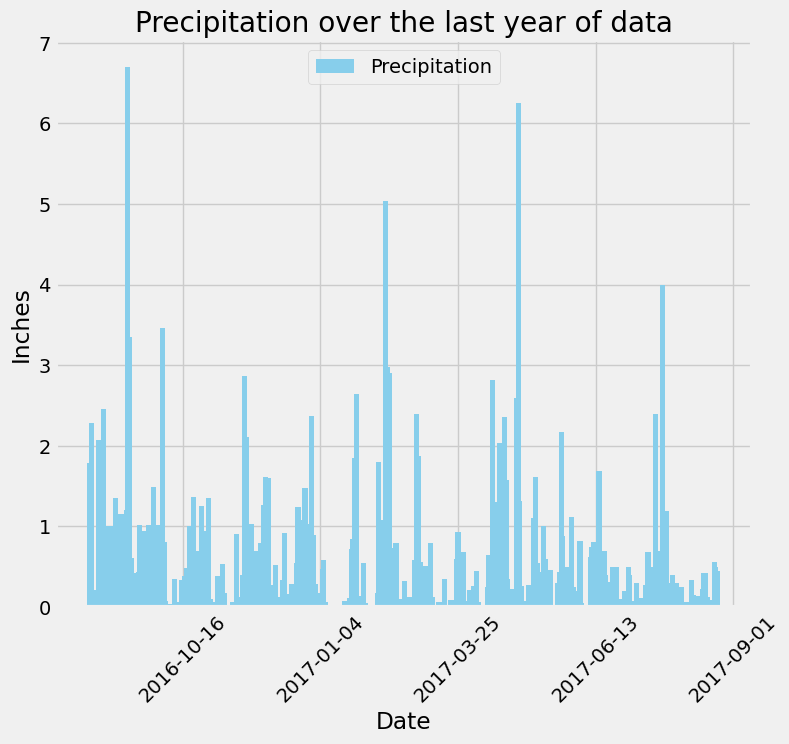

In [42]:
# Ensure your 'date' column is datetime formatted
date_df['date'] = pd.to_datetime(date_df['date'])

plt.figure(figsize=(8, 7))  # Optional: Set the figure size
plt.bar(date_df['date'], date_df['precipitation'], color='skyblue', width=3, label='Precipitation')

# Set x-axis major locator to show only specific dates
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=80))
# Rotate date labels for better readability
plt.xticks(rotation=45)

# Adding titles and labels
plt.title('Precipitation over the last year of data')
plt.xlabel('Date')
plt.ylabel('Inches')
plt.legend(loc='upper center')

# Display the bar chart
plt.show()

In [43]:
# Use Pandas to calculate the summary statistics for the precipitation data
summary_stats = date_df['precipitation'].describe()
summary_stats_df= pd.DataFrame(summary_stats)
summary_stats_df

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [44]:
# Find the column names in the data set for Station.
first_row = session.query(Station).first()
first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x1f001f56630>,
 'name': 'WAIKIKI 717.2, HI US',
 'longitude': -157.8168,
 'latitude': 21.2716,
 'id': 1,
 'station': 'USC00519397',
 'elevation': 3.0}

In [45]:
# Design a query to calculate the total number of stations in the dataset
total_count = session.query(func.count(func.distinct(Measurement.station))).scalar()
print(total_count)

9


In [46]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
station_count = session.query(Measurement.station, func.count(Measurement.station).label('count')) \
    .group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()
# Convert results to a list
output_list = [(station, count) for station, count in station_count]

# Print the output list
print("Count of each station in descending order:")
for station, count in output_list:
    print(f"{station}: {count}")

Count of each station in descending order:
USC00519281: 2772
USC00519397: 2724
USC00513117: 2709
USC00519523: 2669
USC00516128: 2612
USC00514830: 2202
USC00511918: 1979
USC00517948: 1372
USC00518838: 511


In [47]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
min_tobs = session.query(func.min(Measurement.tobs)) \
                  .filter(Measurement.station == 'USC00519281').scalar()
max_tobs = session.query(func.max(Measurement.tobs)) \
                  .filter(Measurement.station == 'USC00519281').scalar()
avg_tobs = session.query(func.avg(Measurement.tobs)) \
                  .filter(Measurement.station == 'USC00519281').scalar()

print(f"Lowest temp 'USC00519281': {min_tobs}")
print(f"Highest temp 'USC00519281': {max_tobs}")
print(f"Average temp 'USC00519281': {avg_tobs}")

Lowest temp 'USC00519281': 54.0
Highest temp 'USC00519281': 85.0
Average temp 'USC00519281': 71.66378066378067


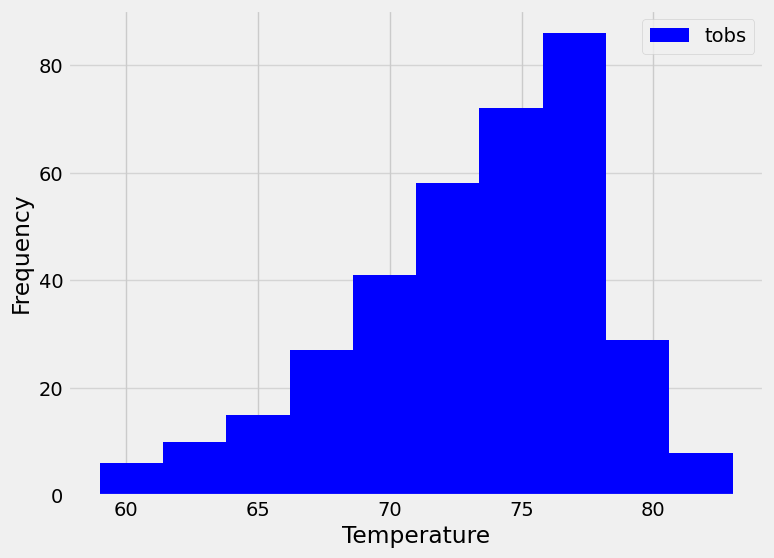

In [52]:
# Clear any previous figures
plt.close('all')

# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
results = session.query(Measurement).filter(Measurement.date > query_date)\
                                     .filter(Measurement.station == 'USC00519281').all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
station_df = pd.DataFrame([result.__dict__ for result in results])
station_df = station_df.drop(columns=['_sa_instance_state'])

# Sort the dataframe by date
date2_df = station_df.sort_values(by='date', ascending=True)

# Create a histogram of the 'tobs' column
plt.figure(figsize=(8, 6));  # The semicolon suppresses extra output in Jupyter
plt.hist(date2_df['tobs'], color='blue', label='tobs')

# Adding titles and labels
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.legend(loc='upper right')
plt.grid(axis='y', alpha=0.75)

# Display the histogram
plt.show()

# Close Session

In [53]:
# Close Session
session.close()